### LGBM

In [1]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


In [2]:
# 모델
import lightgbm as lgb

# Dataset 관련
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_9.csv')
#df = df.iloc[:1000]
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

before:  (134494, 84)


In [15]:
# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
print("after: ", df.shape)

# 독립변수 카테고리화
target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id'])) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m'].values # 종속변수

after:  (132446, 81)


/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_60165/3725185042.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1


In [6]:
# 시계열 train, test split
split = int(len(df) * 0.8)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
def lgbm_eval(pred, label): # pred, y_test
    # 분류 성능 확인
    predictions = np.array(pred)
    target_np = np.array(label)

    # Data imbalance check
    print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
    print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
    print('-----------------------------------')

    # metrics
    accuracy = accuracy_score(target_np, predictions) # 정확도 계산
    precision = precision_score(target_np, predictions) # 정밀도 계산
    recall = recall_score(target_np, predictions) # 재현율 계산
    f1 = f1_score(target_np, predictions) # F1 스코어 계산

    print(f'Accuracy: {accuracy.round(4)}')
    print(f'Precision: {precision.round(4)}')
    print(f'Recall: {recall.round(4)}')
    print(f'F1 Score: {f1.round(4)}')
    print('-----------------------------------')

    # confusion matrix
    cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
    fig, ax = plt.subplots() # 혼동 행렬 시각화
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    plt.show()


[LightGBM] [Info] Number of positive: 52825, number of negative: 53131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19429
[LightGBM] [Info] Number of data points in the train set: 105956, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498556 -> initscore=-0.005776
[LightGBM] [Info] Start training from score -0.005776
0(negative) target ratio: 0.5115892789731974
1(positive) target ratio: 0.48841072102680255
-----------------------------------
Accuracy: 0.7211
Precision: 0.8549
Recall: 0.5165
F1 Score: 0.644
-----------------------------------


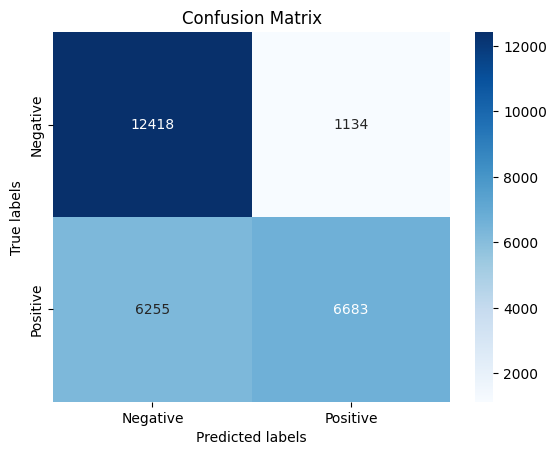

In [26]:
# split 
split_model = lgb.LGBMClassifier(importance_type='split', random_state=10) # type = split or gain
split_model.fit(X_train, y_train)
split_pred = split_model.predict(X_test)

lgbm_eval(split_pred, y_test)

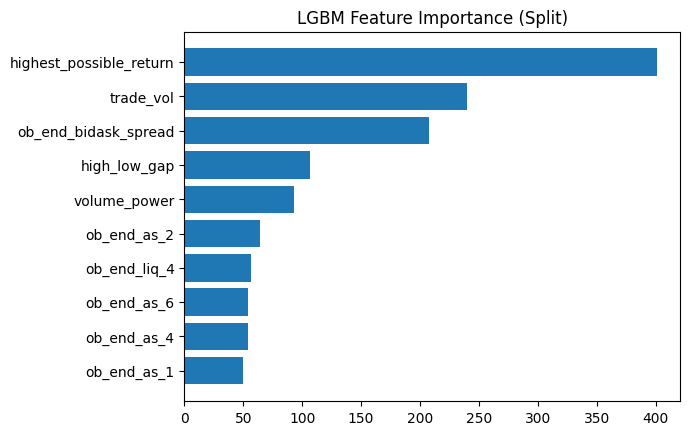

In [27]:
split_importance = split_model.feature_importances_

feature_names = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']).columns
split_importance_df = pd.DataFrame({'Feature':feature_names, 'Split':split_importance})
split_importance_df = split_importance_df.sort_values(by='Split', ascending=False) # sort by split
split_importance_df_top10 = split_importance_df.iloc[:10] # top 10 featues
reversed_split_importance_df_top10 = split_importance_df_top10[::-1] # reverse

plt.barh(reversed_split_importance_df_top10['Feature'], reversed_split_importance_df_top10['Split'])
plt.title('LGBM Feature Importance (Split)')
plt.show()

[LightGBM] [Info] Number of positive: 52825, number of negative: 53131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19429
[LightGBM] [Info] Number of data points in the train set: 105956, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498556 -> initscore=-0.005776
[LightGBM] [Info] Start training from score -0.005776
0(negative) target ratio: 0.5115892789731974
1(positive) target ratio: 0.48841072102680255
-----------------------------------
Accuracy: 0.7211
Precision: 0.8549
Recall: 0.5165
F1 Score: 0.644
-----------------------------------


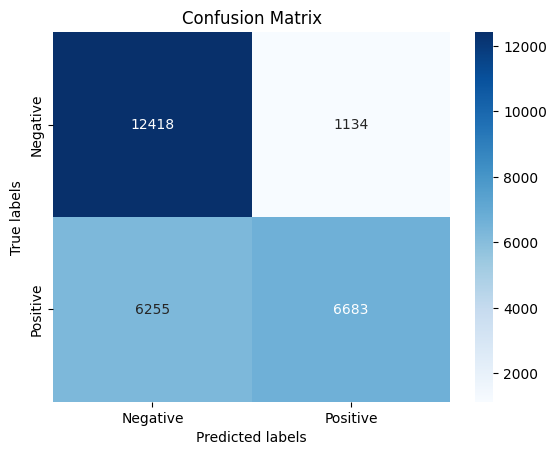

In [28]:
# gain
gain_model = lgb.LGBMClassifier(importance_type='gain', random_state=10) # type = split or gain
gain_model.fit(X_train, y_train)
gain_pred = gain_model.predict(X_test)

lgbm_eval(gain_pred, y_test)

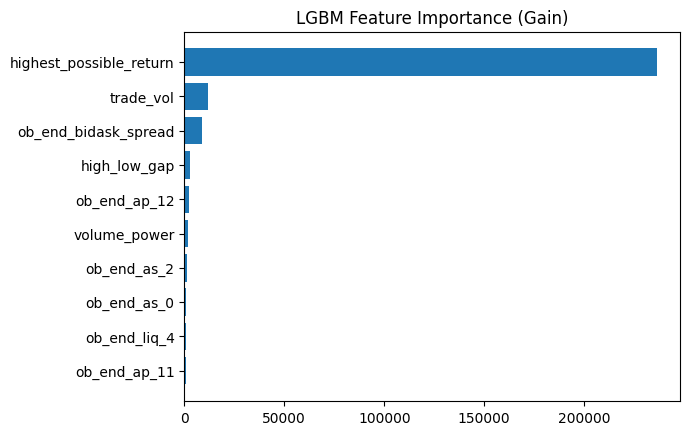

In [29]:
gain_importance = gain_model.feature_importances_

feature_names = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']).columns
gain_importance_df = pd.DataFrame({'Feature':feature_names, 'Gain':gain_importance})
gain_importance_df = gain_importance_df.sort_values(by='Gain', ascending=False) # sort by split
gain_importance_df_top10 = gain_importance_df.iloc[:10] # top 10 featues
reversed_gain_importance_df_top10 = gain_importance_df_top10[::-1] # reverse

plt.barh(reversed_gain_importance_df_top10['Feature'], reversed_gain_importance_df_top10['Gain'])
plt.title('LGBM Feature Importance (Gain)')
plt.show()